In [1]:
! git clone https://github.com/jccf12/career_village_challenge.git

Cloning into 'career_village_challenge'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 161 (delta 59), reused 64 (delta 24), pack-reused 56
Receiving objects: 100% (161/161), 82.42 MiB | 13.28 MiB/s, done.
Resolving deltas: 100% (77/77), done.
Checking out files: 100% (37/37), done.


In [2]:
!pip install shap

     |████████████████████████████████| 327kB 5.4MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463905 sha256=f1002bf0c72f54bdfe9778d13b384f5a4d42b4488e34a3c816800dbc1efdcc7d
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import seaborn as sns
from scipy import stats as sts
import shap
import random
from bs4 import BeautifulSoup
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from dateutil import parser
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

random.seed(30)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
cd career_village_challenge/

/content/career_village_challenge


In [3]:
answers = pd.read_csv("data/answers.csv")
answers_scores = pd.read_csv("data/answer_scores.csv")

#comments = pd.read_csv("data/comments.csv")

emails1 = pd.read_csv("data/emails1.csv")
emails2 = pd.read_csv("data/emails2.csv")
emails = pd.concat([emails1,emails2])

group_members = pd.read_csv("data/group_memberships.csv")
groups = pd.read_csv("data/groups.csv")

matches1 = pd.read_csv("data/matches1.csv")
matches2 = pd.read_csv("data/matches2.csv")
matches3 = pd.read_csv("data/matches3.csv")
matches = pd.concat([matches1,matches2,matches3])

professionals = pd.read_csv("data/professionals.csv")

questions = pd.read_csv("data/questions.csv")
question_scores = pd.read_csv("data/question_scores.csv")

schools_members = pd.read_csv("data/school_memberships.csv")
students = pd.read_csv("data/students.csv")

tag_users = pd.read_csv("data/tag_users.csv")
tag_questions = pd.read_csv("data/tag_questions.csv")
tags = pd.read_csv("data/tags.csv")

In [4]:
def get_user_tags(user_id):
    user_tags = tag_users[tag_users["tag_users_user_id"] == user_id]["tag_users_tag_id"]
    tags_names =tags.loc[tags["tags_tag_id"].isin(user_tags)]
    return(tags)

In [5]:
def get_user_answers(user_id):
    all_answers = answers.loc[answers["answers_author_id"]==user_id]
    return all_answers

In [6]:
def match_email_question(email_date):
    f = lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S UTC+0000")
    b  =f(email_date)
    t = questions["questions_date_added"].apply(f)
    return questions.iloc[(b-t).abs().argsort()[:1]]

In [7]:
# get only emails that were sent immediately after getting the question (ignore the weekly newsletter emails)
immediate_emails = emails[emails["emails_frequency_level"]=="email_notification_immediate"]

# get the matches of the immediate emails only
immediate_matches = matches[matches["matches_email_id"].isin(immediate_emails["emails_id"])]
# get the emails that have their matches only (the data is missing the matches of some emails so we ignore those)
immediate_emails = immediate_emails[immediate_emails["emails_id"].isin(matches["matches_email_id"])]
# some renaming for convience
immediate_emails = immediate_emails.rename(columns={'emails_id':"id"})
immediate_matches = immediate_matches.rename(columns={'matches_email_id':"id"})
# let's put the emails and their matches question id:
emails_questions = pd.merge(immediate_emails, immediate_matches, how="left", on="id")
#some renaming:
emails_questions = emails_questions.rename(columns = {"matches_question_id": "question_id", "emails_recipient_id": "professional_id"})
answers = answers.rename(columns = {"answers_question_id": "question_id", "answers_author_id": "professional_id"})

# now, let's make a big data that has emails, questions sent, and answers. Note that some professionals provided more than
# one answer to the same question. So this means the email Id will be repeated because it has two answers
full_data = pd.merge(emails_questions, answers,how='left',  on=["professional_id","question_id" ])
full_data = full_data.rename(columns = {"id": "email_id"})

# get the target variable by looking ad the answer and putting 1 if it exists and 0 if not:
target = full_data['answers_id'].fillna(0)
target = pd.to_numeric(target, errors='coerce').fillna(1).astype(int) #here just turn str to NA then replace with 1
full_data["q_answered?"] = target

# turn the email sent date into a datetime value instead of a string
date_vectorizer = lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S UTC+0000")
full_data["emails_date_sent"] = full_data["emails_date_sent"].apply(date_vectorizer)
# turn the asnwer added data to datetime value instead of a string (while ignoring the NAs)
indices = full_data["answers_date_added"][full_data["answers_date_added"].notnull()].index.values
full_data.loc[indices, "answers_date_added"] = full_data["answers_date_added"][full_data["answers_date_added"].notnull()].apply(date_vectorizer)
#adding the time taken for each professional to answer a question
full_data["time_taken"] =  pd.to_datetime(full_data["answers_date_added"]) - pd.to_datetime(full_data["emails_date_sent"])

# some people were too active and answered the question even before the email was sent to them. So that would lead
# to a negative time_taken. So we fix that by putting a zero for the time they took (they answered it immediately)
indices2 = full_data["time_taken"][full_data["time_taken"] < datetime.timedelta( days=0)].index.values
full_data.loc[indices2, "time_taken"]=datetime.timedelta(days=0, seconds=0,minutes=0, hours=0 )
# get all the tags of each question
tag_questions_names = pd.merge(tag_questions.rename(columns = {"tag_questions_tag_id":"tag_id"}), tags.rename(columns = {"tags_tag_id":"tag_id"}),how='left',  on=["tag_id" ])
tag_questions_names = tag_questions_names.rename(columns ={"tag_questions_question_id":"question_id", "tags_tag_name":"tag_name"})
questions_tags = tag_questions_names.groupby("question_id")["tag_name"].apply(list).reset_index(name="q_tags")
full_data = pd.merge(full_data,questions_tags,how='left',  on=["question_id" ])

In [8]:
# creating a data for all the professionals
professionals_dataset = pd.DataFrame(columns = ["professional_id"])
professionals_dataset["professional_id"] = professionals["professionals_id"]
# getting the response rate by counting the number of questions answered after the email was sent
response = full_data.groupby("professional_id").mean().drop(columns = ["email_id"]).reset_index()
professionals_dataset = pd.merge(professionals_dataset, response,how='left',  on=["professional_id" ])
professionals_dataset = professionals_dataset.rename(columns = {"q_answered?": "response_rate"})

# getting the average time they took to answer the question if they did
grouped = full_data.groupby('professional_id')["time_taken"]
time_mean = grouped.apply(lambda x: np.mean(x))
professionals_dataset = pd.merge(professionals_dataset, time_mean,how='left',  on=["professional_id" ])
professionals_dataset=  professionals_dataset.rename(columns ={"time_taken": "avg_time_taken"})
# count the total number of questions that each professional answered (including those answered after email)
answers_count = answers["professional_id"].value_counts().reset_index().rename(columns = {"professional_id":"number_q_answered","index":"professional_id",  })
professionals_dataset = pd.merge(professionals_dataset, answers_count,how='left',  on=["professional_id" ])
professionals_dataset["number_q_answered"]= professionals_dataset["number_q_answered"].fillna(0)

# get all the tags that each professional is following
all_tags = pd.merge(tag_users.rename(columns = {"tag_users_tag_id": "tag_id"}),tags.rename(columns = {"tags_tag_id": "tag_id"}),how='left',  on=["tag_id" ])
foll_tags = all_tags.groupby('tag_users_user_id')['tags_tag_name'].apply(list).reset_index(name='following_tags').rename(columns = {"tag_users_user_id": "professional_id"})
professionals_dataset = pd.merge(professionals_dataset, foll_tags,how='left',  on=["professional_id" ])
# get all the tags of the questions that he answered before
a = full_data[["professional_id","q_tags"]][full_data["q_tags"].notnull()].groupby("professional_id")["q_tags"].agg(sum)
professionals_dataset = pd.merge(professionals_dataset, a,how='left',  on=["professional_id" ])
professionals_dataset = professionals_dataset.rename(columns = {"q_tags": "prev_q_tags"})
# get the average score for each professional

prof_score = pd.merge(answers[["professional_id","answers_id" ]], answers_scores.rename(columns = {"id":"answers_id"}),how='left',  on=["answers_id" ]).drop(columns = ["answers_id"])
score_mean = prof_score.groupby("professional_id").mean().reset_index()
professionals_dataset = pd.merge(professionals_dataset,score_mean,how='left',  on=["professional_id" ]).rename(columns = {"score":"avg_ansrs_score"})
professionals_dataset["avg_ansrs_score"] = professionals_dataset["avg_ansrs_score"].fillna(0)
# get the number of groups that each professional is following
prof_grp = group_members["group_memberships_user_id"].value_counts().reset_index().rename(columns = {"index":"professional_id", "group_memberships_user_id":"num_groups"})
professionals_dataset = pd.merge(professionals_dataset,prof_grp,how='left',  on=["professional_id" ])
# get the number of schools that each professional is following
prof_schl = schools_members["school_memberships_user_id"].value_counts().reset_index().rename(columns = {"index":"professional_id", "school_memberships_user_id":"num_schools"})
professionals_dataset = pd.merge(professionals_dataset,prof_schl,how='left',  on=["professional_id" ])

#get the answers to email ratio (#answers/#emails sent) for each professional
prof_emls = immediate_emails["emails_recipient_id"].value_counts().reset_index().rename(columns = {"index":"professional_id", "emails_recipient_id":"num_emails"})
professionals_dataset = pd.merge(professionals_dataset,prof_emls,how='left',  on=["professional_id" ])
professionals_dataset["answrs_emails_ratio"] = professionals_dataset["number_q_answered"] / professionals_dataset["num_emails"]


In [11]:
full_data.head(1)

,Unnamed: 0_x,email_id,professional_id,emails_date_sent,emails_frequency_level,Unnamed: 0_y,question_id,answers_id,answers_date_added,answers_body,q_answered?,time_taken,q_tags
0,292,508143,0c673e046d824ec0ad0ebe012a0673e4,2016-05-20 20:07:48,email_notification_immediate,3291613,b551946952ae4328864414a9164a95d8,NaN,NaN,NaN,0,NaT,"[guidance-counselor, school-counselor, school,..."


In [12]:
professionals_dataset.head(5)

,professional_id,Unnamed: 0_x,Unnamed: 0_y,response_rate,avg_time_taken,number_q_answered,following_tags,prev_q_tags,avg_ansrs_score,num_groups,num_schools,num_emails,answrs_emails_ratio
0,9ced4ce7519049c0944147afb75a8ce3,NaN,NaN,NaN,NaT,1.0,NaN,NaN,5.000000,NaN,NaN,NaN,NaN
1,f718dcf6d2ec4cb0a52a9db59d7f9e67,NaN,NaN,NaN,NaT,0.0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
2,0c673e046d824ec0ad0ebe012a0673e4,329.342857,2.402384e+06,0.0,NaT,39.0,"[consulting, education, consulting, education,...","[guidance-counselor, school-counselor, school,...",1.974359,NaN,NaN,70.0,0.557143
3,977428d851b24183b223be0eb8619a8c,NaN,NaN,NaN,NaT,23.0,NaN,NaN,1.478261,NaN,NaN,NaN,NaN
4,e2d57e5041a44f489288397c9904c2b2,NaN,NaN,NaN,NaT,0.0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN


#Adding more topics/tags from questions (ignore for now)

In [9]:
#Functions for NLP and topic modeling


def lowercase(input):
  return input.lower()

def remove_punctuation(input):
  return input.translate(str.maketrans('','', string.punctuation))

def remove_whitespaces(input):
  return " ".join(input.split())
  
def remove_html_tags(input):
    soup = BeautifulSoup(input, "html.parser")
    stripped_input = soup.get_text(separator=" ")
    return stripped_input

def tokenize(input):
  return word_tokenize(input)

def remove_stop_words(input):
  input = word_tokenize(input)
  return [word for word in input if word not in stopwords.words('english')]

def lemmatize(input):
  lemmatizer=WordNetLemmatizer()
  input_str=word_tokenize(input)
  new_words = []
  for word in input_str:
    new_words.append(lemmatizer.lemmatize(word))
  return ' '.join(new_words)

#Function that calls all other functions together to perform NLP on a given text
def nlp_pipeline(input):
  return lemmatize(' '.join(remove_stop_words(remove_whitespaces(remove_punctuation(remove_html_tags(lowercase(input)))))))

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

#Turn tags into a set for faster checking of whether a tag exists or not
unique_tags = set(tags['tags_tag_name'])

def find_topics(question_body):
  """
  Function that takes a question as an input, and finds the two most important topics/tags
  If the found topics exist in the already existing database of tags, we add these tags
  to the professional who answered the question
  """
  try:
    text = nlp_pipeline(question_body)
    count_vectorizer = CountVectorizer(stop_words='english')
    count_data = count_vectorizer.fit_transform([text])
    # One topic that has an avg of two words because most questions had 1/2 tags
    number_topics = 1
    number_words = 2
    # Create and fit the LDA model
    lda = LDA(n_components=number_topics, n_jobs=-1)
    lda.fit(count_data)

    words = count_vectorizer.get_feature_names()

    #Get topics from model. They are represented as a list e.g. ['military','army']
    topics = [[words[i] for i in topic.argsort()[:-number_words - 1:-1]] for (topic_idx, topic) in enumerate(lda.components_)]
    topics = np.array(topics).ravel()
    #Only use topics for which a tag already exists
    existing_topics = set.intersection(set(topics),unique_tags)
  
  except:
    print(question_body)
    return (question_body)

  return existing_topics

In [ ]:
# let's get the answers' authors first:
my_answers_authors = answers.drop(columns = ["answers_date_added", "answers_body"])
my_answers_authors.head(1)

,answers_id,professional_id,question_id
0,4e5f01128cae4f6d8fd697cec5dca60c,36ff3b3666df400f956f8335cf53e09e,332a511f1569444485cf7a7a556a5e54


In [ ]:
# let's now get the questions_body with the question id:
my_questions_body = questions[["questions_id", "questions_body"]].rename(columns = {"questions_id":"question_id"})
my_questions_body.head(1)

,question_id,questions_body
0,332a511f1569444485cf7a7a556a5e54,What is a maths teacher? what is a ma...


In [ ]:
# let's merge these together:
add_them = pd.merge(my_answers_authors,my_questions_body,how='left',  on=["question_id" ])
add_them.head(1)

,answers_id,professional_id,question_id,questions_body
0,4e5f01128cae4f6d8fd697cec5dca60c,36ff3b3666df400f956f8335cf53e09e,332a511f1569444485cf7a7a556a5e54,What is a maths teacher? what is a ma...


In [ ]:
# let's drop the columns that we don't need:
our_final_data = add_them.drop(columns = ["answers_id", "question_id"])
our_final_data.head(1)

,professional_id,questions_body
0,36ff3b3666df400f956f8335cf53e09e,What is a maths teacher? what is a ma...


In [ ]:
cd ..

/content


In [ ]:
# let's apply the function and get our new tags:

import time

start = time.time()

new_tags= our_final_data["questions_body"].apply(find_topics).values

# let's add it as a column:
our_final_data["new_tags"] = new_tags
end = time.time()
print(end - start)

In [ ]:
#Alternatively just import the results from a pickle file
import pickle
f = open('store.pckl', 'rb')
new_tags = pickle.load(f)
f.close()
our_final_data["new_tags"] = new_tags

In [ ]:
#group the tags of the same professionals in a list (this will be many tags for each professionl because 
# for each question they answer, they get two new tags)
our_final_data = our_final_data.groupby("professional_id")["new_tags"].apply(list).reset_index()


In [ ]:
our_final_data['new_tags'] = our_final_data['new_tags'].apply(lambda x: list(set.union(*x)))

In [ ]:
# finally, let's merge the new tags with the prev tags we had:
toy = pd.merge(professionals_dataset,our_final_data,how='left',  on=["professional_id" ])

#Fixed a previous bug here
professionals_dataset['prev_q_tags'].update(toy.pop('new_tags'))


In [ ]:
# final data: 
professionals_dataset.head(5)

,professional_id,Unnamed: 0_x,Unnamed: 0_y,response_rate,avg_time_taken,number_q_answered,following_tags,prev_q_tags,avg_ansrs_score,num_groups,num_schools,num_emails,answrs_emails_ratio
0,9ced4ce7519049c0944147afb75a8ce3,NaN,NaN,NaN,NaT,1.0,NaN,"[consulting, resume]",5.000000,NaN,NaN,NaN,NaN
1,f718dcf6d2ec4cb0a52a9db59d7f9e67,NaN,NaN,NaN,NaT,0.0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
2,0c673e046d824ec0ad0ebe012a0673e4,329.342857,2.402384e+06,0.0,NaT,39.0,"[consulting, education, consulting, education,...","[know, strength, love, college, resume, police...",1.974359,NaN,NaN,70.0,0.557143
3,977428d851b24183b223be0eb8619a8c,NaN,NaN,NaN,NaT,23.0,NaN,"[know, investigation, artist, college, law, ma...",1.478261,NaN,NaN,NaN,NaN
4,e2d57e5041a44f489288397c9904c2b2,NaN,NaN,NaN,NaT,0.0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN


#Add more topics from answers (ignore for now)

In [ ]:
# let's get the answers' authors first:
my_answers_authors = answers.drop(columns = ["answers_date_added", "answers_body"])
my_answers_authors.head(1)

,answers_id,professional_id,question_id
0,4e5f01128cae4f6d8fd697cec5dca60c,36ff3b3666df400f956f8335cf53e09e,332a511f1569444485cf7a7a556a5e54


In [ ]:
# let's now get the answers_body with the question id:
my_answers_body = answers[["answers_id", "answers_body"]].rename(columns = {"answers_id":"answers_id"})
my_answers_body.head(1)

,answers_id,answers_body
0,4e5f01128cae4f6d8fd697cec5dca60c,<p>Hi!</p>\n<p>You are asking a very interesti...


In [ ]:
# let's merge these together:
add_them = pd.merge(my_answers_authors,my_answers_body,how='left',  on=["answers_id" ])
add_them.head(1)

,answers_id,professional_id,question_id,answers_body
0,4e5f01128cae4f6d8fd697cec5dca60c,36ff3b3666df400f956f8335cf53e09e,332a511f1569444485cf7a7a556a5e54,<p>Hi!</p>\n<p>You are asking a very interesti...


In [ ]:
# let's drop the columns that we don't need:
our_final_data = add_them.drop(columns = ["answers_id", "question_id"])
our_final_data.head(1)

,professional_id,answers_body
0,36ff3b3666df400f956f8335cf53e09e,<p>Hi!</p>\n<p>You are asking a very interesti...


In [ ]:
# let's apply the function and get our new tags:

import time

start = time.time()

new_tags= our_final_data["answers_body"].apply(find_topics).values

# let's add it as a column:
our_final_data["new_tags"] = new_tags
end = time.time()
print(end - start)

In [ ]:
#Alternatively just import the results from a pickle file
import pickle
f = open('store.pckl', 'rb')
new_tags = pickle.load(f)
f.close()
our_final_data["new_tags"] = new_tags

-------------------

#Clustering model

In [10]:
#Import spacy for similarity calculation
!python -m spacy download en_core_web_lg
import en_core_web_lg
nlp = en_core_web_lg.load()

In [12]:
#Use spacy to find similarities between tags
tag_list =  list(tags['tags_tag_name'])
#3871 contains nan so delete it
del tag_list[3871]
corpus = ' '.join(list(tag_list)).replace('-',' ')
words = corpus.split()
corpus = " ".join(sorted(set(words), key=words.index))
tokens = nlp(corpus)

#Convert tags into vectors
word_vectors = []
for i in tokens:
  word_vectors.append(i.vector)
word_vectors = np.array(word_vectors)

In [13]:
#Fit model
from sklearn.cluster import DBSCAN

#Use cosine because spacy uses cosine
dbscan = DBSCAN(metric='cosine', eps=0.3, min_samples=2).fit(word_vectors)

In [14]:
print(len(set(dbscan.labels_)))
print(set(dbscan.labels_))

1131
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,

In [15]:
#Function for returning label prediction
def dbscan_predict(model, X):

    nr_samples = X.shape[0]

    y_new = np.ones(shape=nr_samples, dtype=int) * -1

    for i in range(nr_samples):
        diff = model.components_ - X[i, :]  # NumPy broadcasting

        dist = np.linalg.norm(diff, axis=1)  # Euclidean distance

        shortest_dist_idx = np.argmin(dist)

        if dist[shortest_dist_idx] < model.eps:
            y_new[i] = model.labels_[model.core_sample_indices_[shortest_dist_idx]]

    return y_new


In [35]:
test_words = ' '.join(['university', 'computer', 'colleges', 'education', 'courses']).replace('-', ' ')
test_tokens = nlp(test_words)

test_vectors = []
for i in test_tokens:
  test_vectors.append(i.vector)
test_vectors = np.array(test_vectors)

In [42]:
def Intersection(topics1, topics2):
    """
    Number of topics in common
    """
    topics1 = ' '.join(topics1).replace('-',' ')
    topics2 = ' '.join(topics2).replace('-',' ')

    topics1 = nlp(topics1)
    topics2 = nlp(topics2)

    topics1 = np.array([i.vector for i in topics1])
    topics2 = np.array([i.vector for i in topics2])

    topics1 = [dbscan_predict(dbscan,np.array([i]))[0]  for i in topics1]
    topics2 = [dbscan_predict(dbscan,np.array([i]))[0]  for i in topics2]

    return len(set(topics1).intersection(topics2))
def IoU(topics1, topics2): 
    """
    Intersection over Union: number of intersecting topics over the total number of topics
    
    """
    topics1 = ' '.join(topics1).replace('-',' ')
    topics2 = ' '.join(topics2).replace('-',' ')

    topics1 = nlp(topics1)
    topics2 = nlp(topics2)

    topics1 = np.array([i.vector for i in topics1])
    topics2 = np.array([i.vector for i in topics2])

    topics1 = [dbscan_predict(dbscan,np.array([i]))[0]  for i in topics1]
    topics2 = [dbscan_predict(dbscan,np.array([i]))[0]  for i in topics2]

    return (len(set(topics1).intersection(topics2))/ (len(topics1)+len(topics2)))
def IoI(topics1, topics2):
    """
    Intersection over Interest: number of intersecting topics over the number of topics of the prof's interest
    """
    topics1 = ' '.join(topics1).replace('-',' ')
    topics2 = ' '.join(topics2).replace('-',' ')

    topics1 = nlp(topics1)
    topics2 = nlp(topics2)

    topics1 = np.array([i.vector for i in topics1])
    topics2 = np.array([i.vector for i in topics2])

    topics1 = [dbscan_predict(dbscan,np.array([i]))[0]  for i in topics1]
    topics2 = [dbscan_predict(dbscan,np.array([i]))[0]  for i in topics2]

    return (len(set(topics1).intersection(topics2))/ (len(topics1)))

In [25]:
model_dataset = pd.merge(full_data,professionals_dataset,how='left',  on=["professional_id" ])

# delete duplicates in the topics
indices = model_dataset["following_tags"][model_dataset["following_tags"].notnull()].index.values
model_dataset.loc[indices, "following_tags"] = model_dataset["following_tags"][model_dataset["following_tags"].notnull()].apply(set).apply(list)

indices = model_dataset["prev_q_tags"][model_dataset["prev_q_tags"].notnull()].index.values
model_dataset.loc[indices, "prev_q_tags"] = model_dataset["prev_q_tags"][model_dataset["prev_q_tags"].notnull()].apply(set).apply(list)

In [26]:
model_dataset["following_tags"]= model_dataset["following_tags"].fillna("Na")
model_dataset["prev_q_tags"]= model_dataset["prev_q_tags"].fillna("Na")
model_dataset["q_tags"]= model_dataset["q_tags"].fillna("Na")

In [23]:
model_dataset.head(5)

,Unnamed: 0_x_x,email_id,professional_id,emails_date_sent,emails_frequency_level,Unnamed: 0_y_x,question_id,answers_id,answers_date_added,answers_body,q_answered?,time_taken,q_tags,Unnamed: 0_x_y,Unnamed: 0_y_y,response_rate,avg_time_taken,number_q_answered,following_tags,prev_q_tags,avg_ansrs_score,num_groups,num_schools,num_emails,answrs_emails_ratio
0,292,508143,0c673e046d824ec0ad0ebe012a0673e4,2016-05-20 20:07:48,email_notification_immediate,3291613,b551946952ae4328864414a9164a95d8,NaN,NaN,NaN,0,NaT,"[guidance-counselor, school-counselor, school,...",329.342857,2.402384e+06,0.0,NaT,39.0,"[air-force, google, education, career-choice, ...","[finance, college, international-education, ca...",1.974359,NaN,NaN,70.0,0.557143
1,293,499509,0c673e046d824ec0ad0ebe012a0673e4,2016-05-20 02:27:37,email_notification_immediate,3478847,fc672127796b4a7cb82ee6b1f988ad16,NaN,NaN,NaN,0,NaT,"[university, computer, colleges, education, co...",329.342857,2.402384e+06,0.0,NaT,39.0,"[air-force, google, education, career-choice, ...","[finance, college, international-education, ca...",1.974359,NaN,NaN,70.0,0.557143
2,294,493282,0c673e046d824ec0ad0ebe012a0673e4,2016-05-19 22:20:51,email_notification_immediate,4082953,6fe604f0ec464a79b24ba24ff64c0bde,NaN,NaN,NaN,0,NaT,"[teach-for-america, education]",329.342857,2.402384e+06,0.0,NaT,39.0,"[air-force, google, education, career-choice, ...","[finance, college, international-education, ca...",1.974359,NaN,NaN,70.0,0.557143
3,295,472766,0c673e046d824ec0ad0ebe012a0673e4,2016-05-19 00:43:41,email_notification_immediate,2853395,5f0a810c890d4b6aaa600a4a2aae0537,NaN,NaN,NaN,0,NaT,[education],329.342857,2.402384e+06,0.0,NaT,39.0,"[air-force, google, education, career-choice, ...","[finance, college, international-education, ca...",1.974359,NaN,NaN,70.0,0.557143
4,296,472290,0c673e046d824ec0ad0ebe012a0673e4,2016-05-19 00:18:02,email_notification_immediate,2876266,f11c9d301c594bc798007d2645f04a30,NaN,NaN,NaN,0,NaT,"[teaching, education]",329.342857,2.402384e+06,0.0,NaT,39.0,"[air-force, google, education, career-choice, ...","[finance, college, international-education, ca...",1.974359,NaN,NaN,70.0,0.557143


In [ ]:
#Test intersection with clustering model

import time
start = time.time()
follow_I = model_dataset.apply(lambda x: Intersection(x.following_tags, x.q_tags), axis=1)
end = time.time()

print(end-start)

In [ ]:
follow_IoI = model_dataset.apply(lambda x: IoI(x.following_tags, x.q_tags), axis=1)
follow_IoU = model_dataset.apply(lambda x: IoU(x.following_tags, x.q_tags), axis=1)

prev_I = model_dataset.apply(lambda x: Intersection(x.following_tags, x.q_tags), axis=1)

model_dataset["follow_I"]=follow_I
model_dataset["follow_IoI"]=follow_IoI
model_dataset["follow_IoU"]=follow_IoU
model_dataset["prev_I"]=prev_I

In [ ]:
model_dataset.columns

Index(['Unnamed: 0_x_x', 'email_id', 'professional_id', 'emails_date_sent',
       'emails_frequency_level', 'Unnamed: 0_y_x', 'question_id', 'answers_id',
       'answers_date_added', 'answers_body', 'q_answered?', 'time_taken',
       'q_tags', 'Unnamed: 0_x_y', 'Unnamed: 0_y_y', 'response_rate',
       'avg_time_taken', 'number_q_answered', 'following_tags', 'prev_q_tags',
       'avg_ansrs_score', 'num_groups', 'num_schools', 'num_emails',
       'answrs_emails_ratio', 'follow_I', 'follow_IoI', 'follow_IoU',
       'prev_I'],
      dtype='object')

In [ ]:
model_dataset = model_dataset.drop(columns = ['Unnamed: 0_x_x','Unnamed: 0_y_x','Unnamed: 0_x_y','Unnamed: 0_y_y',"email_id", "professional_id", "emails_date_sent", "emails_frequency_level",
                              "question_id", "answers_id", "answers_date_added", "answers_body", "time_taken",
                              "q_tags", "following_tags",'' "prev_q_tags"])

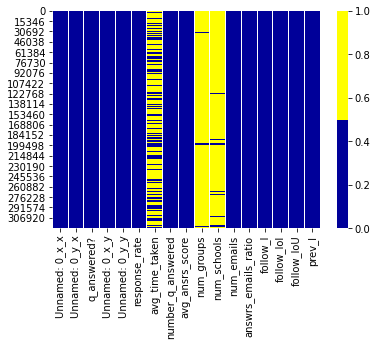

In [ ]:
cols = model_dataset.columns
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(model_dataset[cols].isnull(), cmap=sns.color_palette(colours))

In [ ]:
model_dataset["num_schools"]  =model_dataset["num_schools"].fillna(0)
model_dataset["num_groups"] = model_dataset["num_groups"].fillna(0)

In [ ]:
model_dataset.head(5)

,q_answered?,response_rate,avg_time_taken,number_q_answered,avg_ansrs_score,num_groups,num_schools,num_emails,answrs_emails_ratio,follow_I,follow_IoI,follow_IoU,prev_I
0,0,0.0,NaT,39.0,1.974359,0.0,0.0,70.0,0.557143,1,0.2,0.100000,5
1,0,0.0,NaT,39.0,1.974359,0.0,0.0,70.0,0.557143,1,0.2,0.100000,5
2,0,0.0,NaT,39.0,1.974359,0.0,0.0,70.0,0.557143,1,0.2,0.142857,2
3,0,0.0,NaT,39.0,1.974359,0.0,0.0,70.0,0.557143,1,0.2,0.166667,1
4,0,0.0,NaT,39.0,1.974359,0.0,0.0,70.0,0.557143,1,0.2,0.142857,2


In [ ]:
model_dataset["avg_time_taken"]= model_dataset["avg_time_taken"][model_dataset["avg_time_taken"].notnull()].apply(lambda x: x.total_seconds()/3600)

In [ ]:
model_dataset["avg_time_taken"].describe()

count    112383.000000
mean        212.373288
std         971.146922
min           0.000000
25%           2.229907
50%          11.692668
75%          47.353889
max       12390.666667
Name: avg_time_taken, dtype: float64

In [ ]:
med = model_dataset["avg_time_taken"].median()
model_dataset["avg_time_taken"] = model_dataset["avg_time_taken"].fillna(med)

In [ ]:
positive = model_dataset[ model_dataset["q_answered?"] != 0]
negative = model_dataset[ model_dataset["q_answered?"] == 0]

In [ ]:
negative_sample = negative.sample(5000)

In [ ]:
resampled_data = pd.concat([positive,negative_sample ])

In [ ]:
target = resampled_data["q_answered?"]
resampled_data = resampled_data.drop(columns = ["q_answered?"])

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(resampled_data, target, test_size=0.2, random_state=42)

In [ ]:
#Fit Naive Bayes
gnb = GaussianNB()

gnb.fit(x_train, y_train)

y_pred_gnb = gnb.predict(x_test)

print("Accuracy for naive bayes:",metrics.accuracy_score(y_test, y_pred_gnb))

#Fit Random Forest
clf=RandomForestClassifier(n_estimators=100)
clf.fit(x_train,y_train)
y_pred_forest=clf.predict(x_test)

print("Accuracy for random forest:",metrics.accuracy_score(y_test, y_pred_forest))



#Fit logistic regression
LR = LogisticRegression(max_iter = 10000)
LR.fit(x_train, y_train)
y_pred_lr = LR.predict(x_test)
print("Accuracy for logistic regression:",metrics.accuracy_score(y_test, y_pred_lr))

Accuracy for naive bayes: 0.7416974169741697
Accuracy for random forest: 0.8592514496573537
Accuracy for logistic regression: 0.8408012651555087


In [ ]:
#Without new data
#Accuracy for naive bayes: 0.7496046389035319
#Accuracy for random forest: 0.8740115972588297
#Accuracy for logistic regression: 0.841855561412757


#With new data
#Accuracy for naive bayes: 0.7469688982604111
#Accuracy for random forest: 0.8529256721138639
#Accuracy for logistric regression: 0.8365840801265155

In [ ]:
#LR.classes_
LR.predict_proba(x_test)

array([[8.12686779e-01, 1.87313221e-01],
       [4.19945924e-01, 5.80054076e-01],
       [8.21505065e-01, 1.78494935e-01],
       ...,
       [7.22349090e-01, 2.77650910e-01],
       [2.15409316e-01, 7.84590684e-01],
       [5.06124192e-05, 9.99949388e-01]])

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


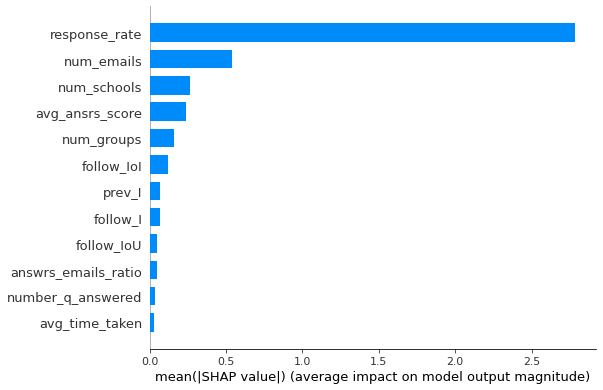

In [ ]:
explainer = shap.LinearExplainer(LR, x_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_train, plot_type="bar")

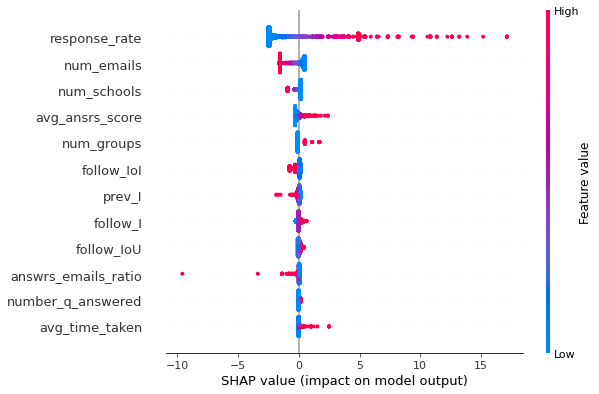

In [ ]:
shap.summary_plot(shap_values, x_test)

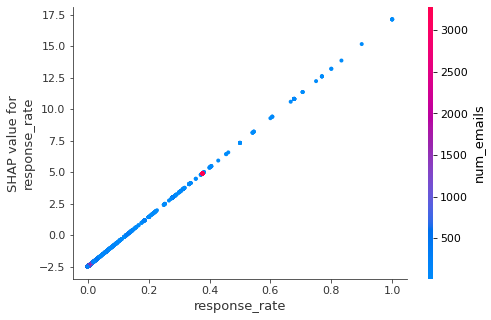

In [ ]:
shap.dependence_plot("response_rate", shap_values, x_test)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], x_test.iloc[0,:])